# Feminism in 19th Century Literature
## An NLP Exploration

I was curious to discover if our NLP tools are sophisticated enough at this juncture to detect feminism in older novels. The language use was more quiet and nuanced and could pose problems for sentiment and topic analysis. In particular, I'd like to see if Jane Austen can be proven as a feminist author. Let's begin by importing our packages!

In [373]:
import os
import glob
import re
import pandas as pd
import numpy as np
from pathlib import Path
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from itertools import *
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import plot_confusion_matrix
import nltk
import spacy
from sklearn.decomposition import NMF
import random
from nltk.corpus import gutenberg
nltk.download('punkt')
nltk.download('gutenberg')
from wordcloud import WordCloud
import networkx as nx
nltk.download('stopwords')
from nltk.corpus import gutenberg, stopwords
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/katherineperkins/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/katherineperkins/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


Next, we will need to import and upload our texts. Cleaning will also need to be done to ensure no extraneous words, spaces, or breaklines are prevalent.

In [2]:
emma = gutenberg.raw('austen-emma.txt')


[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/katherineperkins/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katherineperkins/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
f = open('austen-pride.txt','r')
pride = f.read()
f.close()

In [4]:
f = open('dickens-great.txt','r')
great = f.read()
f.close()

In [5]:
f = open('bronte-wuthering.txt','r')
wuthering = f.read()
f.close()

In [6]:
print('\nRaw:\n', pride[0:100])


Raw:
 
PRIDE AND PREJUDICE

By Jane Austen



Chapter 1


It is a truth universally acknowledged, that a s


In [7]:
# This pattern matches all text between square brackets.
pattern = "[\[].*?[\]]"
title = "PRIDE AND PREJUDICE"
author = "By Jane Austen"

pride = re.sub(title, "", pride)
pride = re.sub(author, "", pride)
great = re.sub(pattern, "", great)
wuthering = re.sub(pattern, "", wuthering)

# Print the first 100 characters of our books again.

print('Title removed:\n', pride[0:200])
print('Title removed:\n', great[0:100])
print('Title removed:\n', wuthering[0:100])

Title removed:
 






Chapter 1


It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.

However little known the feelings or views of such a man may b
Title removed:
 Chapter I

My father's family name being Pirrip, and my Christian name Philip, my
infant tongue coul
Title removed:
 CHAPTER I


I have just returned from a visit to my landlord--the solitary
neighbour that I shall be


In [8]:
# Now we'll match and remove chapter headings.
pride = re.sub(r'Chapter .*', '', pride)
great = re.sub(r'Chapter .*', '', great)
wuthering = re.sub(r'CHAPTER .*', '', wuthering)

# Ok, what's it look like now?
print('Chapter headings removed:\n', pride[0:100])
print('Chapter headings removed:\n', great[0:100])
print('Chapter headings removed:\n', wuthering[0:100])

Chapter headings removed:
 









It is a truth universally acknowledged, that a single man in possession
of a good fortune,
Chapter headings removed:
 

My father's family name being Pirrip, and my Christian name Philip, my
infant tongue could make of
Chapter headings removed:
 


I have just returned from a visit to my landlord--the solitary
neighbour that I shall be troubled


In [9]:
# Now we'll match and remove volume headings.
great = re.sub(r'VOLUME .*', '', great)
wuthering = re.sub(r'VOLUME .*', '', wuthering)

# Ok, what's it look like now?
print('Volume headings removed:\n', great[0:100])

Volume headings removed:
 

My father's family name being Pirrip, and my Christian name Philip, my
infant tongue could make of


In [10]:
# Remove newlines and other extra whitespace by splitting and rejoining.
pride = ' '.join(pride.split())
great = ' '.join(great.split())
wuthering = ' '.join(wuthering.split())

# All done with cleanup? Let's see how it looks.

print('Extra whitespace removed:\n', pride[0:100])
print('Extra whitespace removed:\n', great[0:100])
print('Extra whitespace removed:\n', wuthering[0:100])

Extra whitespace removed:
 It is a truth universally acknowledged, that a single man in possession of a good fortune, must be i
Extra whitespace removed:
 My father's family name being Pirrip, and my Christian name Philip, my infant tongue could make of b
Extra whitespace removed:
 I have just returned from a visit to my landlord--the solitary neighbour that I shall be troubled wi


spaCy will be used to tokenize our documents. Tokenization is important in our to create our Bag of Words and later, our supervised learning models.

In [11]:
#load spacy's english library
nlp = spacy.load('en')

In [12]:
#tokenize books
pride_doc = nlp(pride)
great_doc = nlp(great)
wuthering_doc = nlp(wuthering)

In [13]:
# Let's explore the objects we've built.
print("The emma_doc object is a {} object.".format(type(pride_doc)))
print("It is {} tokens long".format(len(pride_doc)))
print("The first three tokens are '{}'".format(pride_doc[:3]))
print("The type of each token is {}".format(type(pride_doc[0])))

The emma_doc object is a <class 'spacy.tokens.doc.Doc'> object.
It is 144601 tokens long
The first three tokens are 'It is a'
The type of each token is <class 'spacy.tokens.token.Token'>


In [15]:
from collections import Counter
# Utility function to calculate how frequently words appear in the text.
def word_frequencies(text, include_stop=True):
    
    # Build a list of words.
    # Strip out punctuation and, optionally, stop words.
    words = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            words.append(token.text)
            
    # Build and return a Counter object containing word counts.
    return Counter(words)
    
# The most frequent words:
pride_freq = word_frequencies(pride_doc, include_stop=False).most_common(10)
great_freq = word_frequencies(great_doc, include_stop=False).most_common(10)
wuthering_freq = word_frequencies(wuthering_doc, include_stop=False).most_common(10)

print('Pride & Prejudice:', pride_freq)
print('Great Expectations:', great_freq)
print('Wuthering Heights:', wuthering_freq)

Pride & Prejudice: [('Mr.', 782), ('Elizabeth', 633), ('Darcy', 415), ('said', 401), ('Mrs.', 343), ('Bennet', 322), ('Bingley', 305), ('Jane', 291), ('Miss', 281), ('know', 238)]
Great Expectations: [('said', 1339), ('Joe', 740), ('Mr.', 704), ('know', 377), ('Miss', 372), ('time', 366), ('little', 349), ('come', 340), ('Pip', 331), ('looked', 322)]
Wuthering Heights: [('Heathcliff', 476), ('Linton', 403), ('Catherine', 379), ('said', 367), ('Mr.', 307), ('shall', 192), ('master', 183), ('Hareton', 177), ('little', 176), ('like', 155)]


In [16]:
# Pull out just the text from our frequency lists.
pride_common = [pair[0] for pair in pride_freq]
great_common = [pair[0] for pair in great_freq]
wuthering_common = [pair[0] for pair in wuthering_freq]

# Use sets to find the unique values in each top ten.
print('Unique to Pride & Prejudice:', set(pride_common) - set(great_common) - set(wuthering_common))
print('Unique to Great Expectations:', set(great_common) - set(pride_common) - set(wuthering_common))
print('Unique to Wuthering Heights:', set(wuthering_common) - set(great_common) - set(pride_common))

Unique to Pride & Prejudice: {'Mrs.', 'Bennet', 'Darcy', 'Bingley', 'Jane', 'Elizabeth'}
Unique to Great Expectations: {'Joe', 'come', 'time', 'Pip', 'looked'}
Unique to Wuthering Heights: {'Catherine', 'like', 'master', 'Heathcliff', 'Hareton', 'shall', 'Linton'}


Lemmatization is implemented so that we don't have an abundance of repetitive words that essentially mean the same thing. For instance, marriage is a common theme amongst these novels, but we don't need "marry, marriage, married." Lemmatization will take the root of the word, rather than all three.

In [17]:

# Utility function to calculate how frequently lemas appear in the text.
def lemma_frequencies(text, include_stop=True):
    
    # Build a list of lemas.
    # Strip out punctuation and, optionally, stop words.
    lemmas = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            lemmas.append(token.lemma_)
            
    # Build and return a Counter object containing word counts.
    return Counter(lemmas)

# Instantiate our list of most common lemmas.
pride_lemma_freq = lemma_frequencies(pride_doc, include_stop=False).most_common(10)
great_lemma_freq = lemma_frequencies(great_doc, include_stop=False).most_common(10)
wuthering_lemma_freq = lemma_frequencies(wuthering_doc, include_stop=False).most_common(10)


print('Pride & Prejudice:', pride_lemma_freq)
print('Great Expectations:', great_lemma_freq)
print('Wuthering Heights:', wuthering_lemma_freq)

# Again, identify the lemmas common to one text but not the other.

pride_lemma_common = [pair[0] for pair in pride_lemma_freq]
great_lemma_common = [pair[0] for pair in great_lemma_freq]
wuthering_lemma_common = [pair[0] for pair in wuthering_lemma_freq]


print('Unique to Pride & Prejudice:', set(pride_lemma_common) - set(great_lemma_common) - set(wuthering_lemma_common))
print('Unique to Great Expectations:', set(great_lemma_common) - set(wuthering_lemma_common) - set(pride_lemma_common))
print('Unique to Wuthering Heights:', set(wuthering_lemma_common) - set(great_lemma_common) - set(pride_lemma_common))

Pride & Prejudice: [('Mr.', 782), ('Elizabeth', 633), ('say', 450), ('Darcy', 413), ('know', 385), ('Mrs.', 343), ('think', 331), ('Bennet', 322), ('Bingley', 305), ('sister', 294)]
Great Expectations: [('say', 1438), ('Joe', 740), ('come', 722), ('look', 714), ('Mr.', 704), ('know', 656), ('go', 648), ('think', 487), ('hand', 466), ('time', 458)]
Wuthering Heights: [('Heathcliff', 476), ('say', 409), ('Linton', 403), ('Catherine', 373), ('come', 362), ('Mr.', 307), ('think', 236), ('go', 235), ('look', 228), ('tell', 213)]
Unique to Pride & Prejudice: {'Mrs.', 'Bennet', 'sister', 'Darcy', 'Bingley', 'Elizabeth'}
Unique to Great Expectations: {'Joe', 'time', 'hand'}
Unique to Wuthering Heights: {'Catherine', 'tell', 'Heathcliff', 'Linton'}


In [18]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

    

pride_clean = text_cleaner(pride[:int(len(pride)/10)])
great_clean = text_cleaner(great[:int(len(great)/10)])
wuthering_clean = text_cleaner(wuthering[:int(len(wuthering)/10)])

In [19]:
# Group into sentences.
pride_sents = [[sent, "Pride_Prejudice"] for sent in pride_doc.sents]
great_sents = [[sent, "Great_Expectations"] for sent in great_doc.sents]
wuthering_sents = [[sent, "Wuthering_Heights"] for sent in wuthering_doc.sents]

In [20]:
# Combine the sentences from the three novels into one data frame.
sentences2 = pd.DataFrame(pride_sents + great_sents + wuthering_sents)

print(sentences2)

                                                       0                  1
0      (It, is, a, truth, universally, acknowledged, ...    Pride_Prejudice
1      (However, little, known, the, feelings, or, vi...    Pride_Prejudice
2      (", My, dear, Mr., Bennet, ,, ", said, his, la...    Pride_Prejudice
3       (Mr., Bennet, replied, that, he, had, not, ., ")    Pride_Prejudice
4      (But, it, is, ,, ", returned, she, ;, ", for, ...    Pride_Prejudice
...                                                  ...                ...
24734  (had, he, not, fortunately, recognised, me, fo...  Wuthering_Heights
24735  (My, walk, home, was, lengthened, by, a, diver...  Wuthering_Heights
24736  (When, beneath, its, walls, ,, I, perceived, d...  Wuthering_Heights
24737  (I, sought, ,, and, soon, discovered, ,, the, ...  Wuthering_Heights
24738  (I, lingered, round, them, ,, under, that, ben...  Wuthering_Heights

[24739 rows x 2 columns]


In [21]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
pridewords = bag_of_words(pride_doc)
greatwords = bag_of_words(great_doc)
wutheringwords = bag_of_words(wuthering_doc)

# Combine bags to create a set of unique words.
common_words = set(pridewords + greatwords + wutheringwords)

In [ ]:
# Create our data frame with features. This took several days to run so it is commented out.
#word_counts = bow_features(sentences2, common_words)
#word_counts.head()

In [ ]:
#the results of the bow is written to a csv file for future use.
#trio_word_counts = word_counts.to_csv('trio_word_counts.csv')

Once our Bag of Words is created, we will create a dataframe from all of the common words across the three novels. This was very computationally expensive and took several days. The result was written to a .csv file and loaded below for quicker runtime.

In [363]:
trio_word_counts = pd.read_csv('trio_word_counts.csv')
trio_word_counts.head()

,Unnamed: 0,scheme,loud,extremely,hatred,sufficient,drawer,uncomfortable,eh,cry,...,discomposure,library,tiresome,flat,call,Mary,Hareton,impertinence,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"It is a truth universally acknowledged, that a...",Pride_Prejudice
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,However little known the feelings or views of ...,Pride_Prejudice
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"""My dear Mr. Bennet,"" said his lady to him one...",Pride_Prejudice
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"Mr. Bennet replied that he had not. """,Pride_Prejudice
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"But it is,"" returned she; ""for Mrs. Long has j...",Pride_Prejudice


# Supervised Learning Models

Now that we have our BoW, we can run some supervised models. I believe one way we can prove Jane Austen as a feminist author is to see if we can attribute the correct books to the correct authors. If there is a large margin of error, it might prove she wasn't as much of an outlier or "feminist rebel" for her time period as one may have thought.

## Random Forest with BoW

In [364]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = trio_word_counts['text_source']
X = np.array(trio_word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 1.0

Test set score: 0.9995957962813258


In [365]:
print(cross_val_score(rfc, X, Y, cv=5))

[0.7172595  0.99898949 0.99939369 0.99939369 0.71922377]


## Logistic Regression with BoW

In [366]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2')
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(14843, 3449) (14843,)
Training set score: 0.9684699858519167

Test set score: 0.9666531932093775


In [367]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
print(cross_val_score(lr, X, Y, cv=5))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

[0.72554568 0.9997979  1.         0.99858529 0.73478876]


Both of our models are rather overfit and unstable. Perhaps this is because we left the entities in the text before running our BoW? That would definitely make it easier to attribute the correct novel. At any rate, logistic regression performed much better than the random forest, so let's check out our confusion matrix below.

In [368]:
lr_predicted = lr.predict(X_test)
pd.crosstab(y_test, lr_predicted)

col_0,Great_Expectations,Pride_Prejudice,Wuthering_Heights
text_source,,,
Great_Expectations,4032,24,162
Pride_Prejudice,24,2546,0
Wuthering_Heights,120,0,2988


PRIDE AND PREJUDICE
[[4032   24  162]
 [  24 2546    0]
 [ 120    0 2988]]


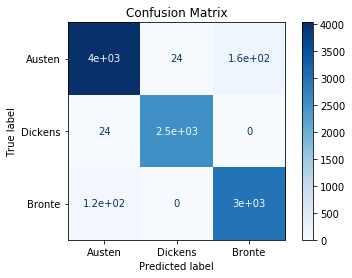

In [369]:
disp = plot_confusion_matrix(lr, X_test, y_test,
                                 display_labels=['Austen', 'Dickens', 'Bronte'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Confusion Matrix')

print(title)
print(disp.confusion_matrix)

plt.show()

# Unsupervised Learning

Again, we will need to import our texts and clean them. This time we will be storing the data in respective dataframes, split by sentence. We will then do some topic modeling to see if when we take into account the context of the sentence, we are better able to see what prevalent themes are within these books.

In [159]:
f = open('dickens-great.txt','r')
great_text = f.read()
great_text = re.sub(r'Chapter .*', '', great_text)
great_text = great_text.strip().replace('\n', ' ')

f.close()

In [160]:
sent = re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)(\s|[A-Z].*)',great_text)


<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<ipython-input-160-a5229b9e8c54>:1: DeprecationWarning: invalid escape sequence \w
  sent = re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)(\s|[A-Z].*)',great_text)


In [43]:
dickens_df = pd.DataFrame(sent, columns=['sentences'])
dickens_df.head(10)

,sentences
0,"My father's family name being Pirrip, and my C..."
1,
2,"So, I called myself Pip, and came to be called..."
3,
4,"I give Pirrip as my father's family name, on ..."
5,
6,"Joe Gargery, who married the blacksmith."
7,
8,"As I never saw my father or my mother, and nev..."
9,


In [44]:
dickens_df = dickens_df.iloc[::2]
dickens_df.head(10)

,sentences
0,"My father's family name being Pirrip, and my C..."
2,"So, I called myself Pip, and came to be called..."
4,"I give Pirrip as my father's family name, on ..."
6,"Joe Gargery, who married the blacksmith."
8,"As I never saw my father or my mother, and nev..."
10,"The shape of the letters on my father's, gave ..."
12,From the character and turn of the inscription...
14,"To five little stone lozenges, each about a fo..."
16,"Ours was the marsh country, down by the river..."
18,My first most vivid and broad impression of th...


In [45]:
pattern = "[\[].*?[\]]"
title = "PRIDE AND PREJUDICE"
author = "By Jane Austen"

In [46]:
f = open("austen-pride.txt", "r")
pride = f.read()
pride = re.sub(r'Chapter .*', '', pride)
pride = pride.strip().replace('\n', ' ')
pride = re.sub(title, "", pride)
pride = re.sub(author, "", pride)
f.close()

In [47]:
pride_sent = re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)(\s|[A-Z].*)',pride)


In [48]:
pride_sent_df = pd.DataFrame(pride_sent, columns=['sentences'])
pride_sent_df.head(10)

,sentences
0,It is a truth universally acknowledge...
1,
2,However little known the feelings or views of...
3,
4,"""My dear Mr. Bennet,"" said his lady to him on..."
5,
6,"""But it is,"" returned she; ""for Mrs."
7,
8,"Long has just been here, and she told me all a..."
9,


In [49]:
pride_sent_df = pride_sent_df.iloc[::2]
pride_sent_df.head(10)

,sentences
0,It is a truth universally acknowledge...
2,However little known the feelings or views of...
4,"""My dear Mr. Bennet,"" said his lady to him on..."
6,"""But it is,"" returned she; ""for Mrs."
8,"Long has just been here, and she told me all a..."
10,"""Do you not want to know who has taken it?"" c..."
12,"""_You_ want to tell me, and I have no objecti..."
14,"""Why, my dear, you must know, Mrs."
16,Long says that Netherfield is taken by a young...
18,"What a fine thing for our girls!"" ""How so?"


In [117]:
f = open("bronte-wuthering.txt", "r")
wuthering = f.read()
wuthering = re.sub(r'CHAPTER .*', '', wuthering)
wuthering = wuthering.strip().replace('\n', ' ')
wuthering = wuthering.strip().replace('_', ' ')
f.close()

In [118]:
wuthering_sent = re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)(\s|[A-Z].*)',wuthering)


In [119]:
wuthering_sent_df = pd.DataFrame(wuthering_sent, columns=['sentences'])
wuthering_sent_df.head(10)

,sentences
0,I have just returned from a visit to my landlo...
1,
2,This is certainly a beautiful country! In al...
3,
4,A perfect misanthropist's heaven: and Mr. Hea...
5,
6,A capital fellow! He little imagined how my ...
7,
8,'Mr. Heathcliff?' I said.
9,


In [120]:
wuthering_sent_df = wuthering_sent_df.iloc[::2]
wuthering_sent_df.head(10)

,sentences
0,I have just returned from a visit to my landlo...
2,This is certainly a beautiful country! In al...
4,A perfect misanthropist's heaven: and Mr. Hea...
6,A capital fellow! He little imagined how my ...
8,'Mr. Heathcliff?' I said.
10,A nod was the answer.
12,"'Mr. Lockwood, your new tenant, sir."
14,I do myself the honour of calling as soon as ...
16,'I should not allow any one to inconvenience ...
18,When he saw my horse's breast fairly pushing ...


# Vectorization

Now that we have our dataframes, we will implement vectorization to extract words that are most prevalent by topic. This time we will remove necessary entities.

## Great Expectations
Before vectorizing our texts, we need to remove entities, so that our topics do not surround pronouns that do not offer a great deal of insight with regards to themes contained in the book.

In [54]:
great_doc_vec = nlp(text)

In [56]:
# All of the unique entities spaCy thinks are people.
people = [entity.text for entity in list(great_doc_vec.ents) if entity.label_ == "PERSON"]
print(set(people))

{'Abel', 'Pip,--which', 'chandler', 'Philip Pip', 'Tom-cats', 'Buster', 'indeed,--more', 'Little Jane', 'performance,--“we', 'Run', 'Mithter Jaggerth', 'recognized,--“it', 'Sarah Pocket', "Uncle Pumblechook's", 'Bondsman', 'Black Bill', 'Good Night', 'fox', 'Cobbs', 'Jaggers', 'Carols', 'Sarah', 'Pip', 'Ask Wemmick', 'Impostor', "Georgiana M'ria", 'Wemmick', 'Bibles', 'Camberwell Green', 'Cousin Raymond', "Miss Havisham's", 'was--“as', "Mother Hubbard's", 'Providence', 'Tom', 'Dependent', 'Lodge', 'Alexander', 'Philip Pirrip', 'Aged P.', "Saint Paul's", 'company,--making', 'Slower', 'Camberwell', 'fire,--destined', 'I. Which', 'Mary Anne', "t'other", 'mitre', 'Wopsle,--and', 'Joseph Gargery', 'green,--a', 'George Barnwell', 'Bobtail', 'Jaggers:--', 'Moses', 'I.', 'candle,--which', 'Joseph.--Joseph', 'Barley', 'Uncle Pumblechook', 'Bridge', 'down,--with', 'Devil', 'knives', 'Die', 'face,--on', 'debt,--very', 'action,--“I', 'Southwark', 'Blandley', 'fungus,--when', 'Dear Pip', 'Mithter--

In [73]:
stop_vec = stopwords.words('english')
additional_stopwords = """pip joe collins estella havisham abel whimple gargery pirrip philip ah ha mr mrs oh"""
stop_vec += additional_stopwords.split()

In [74]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_vec)

In [75]:
dtm = tfidf.fit_transform(dickens_df['sentences'])
dtm

<333x557 sparse matrix of type '<class 'numpy.float64'>'
	with 2370 stored elements in Compressed Sparse Row format>

In [76]:
nmf_model = NMF(n_components=5,random_state=42)
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [78]:
#this is a random sampling of our feature words to be sure our code is working properly.
for i in range(10):
    random_word_id = random.randint(0,557)
    print(tfidf.get_feature_names()[random_word_id])

hand
going
waiting
ankle
eyes
else
ships
best
bib
often


In [79]:
single_topic = nmf_model.components_[0]

In [81]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['hold', 'thought', 'feeling', 'sir', 'terror', 'hears', 'eating', 'liver', 'hid', 'dreadful', 'secret', 'heart', 'boy', 'young', 'man']


THE TOP 15 WORDS FOR TOPIC #1
['wonder', 'never', 'us', 'stared', 'shaking', 'bite', 'general', 'churchyard', 'way', 'matter', 'exclaimed', 'repeated', 'boy', 'know', 'sister']


THE TOP 15 WORDS FOR TOPIC #2
['brandy', 'hulks', 'lookee', 'brought', 'blacksmith', 'firing', 'hear', 'looking', 'cough', 'know', 'us', 'took', 'mother', 'sir', 'said']


THE TOP 15 WORDS FOR TOPIC #3
['put', 'one', 'thought', 'say', 'got', 'upon', 'church', 'never', 'came', 'made', 'would', 'time', 'going', 'like', 'much']


THE TOP 15 WORDS FOR TOPIC #4
['eyes', 'iron', 'moment', 'tilted', 'yes', 'way', 'got', 'great', 'file', 'round', 'bread', 'took', 'butter', 'leg', 'looked']




It's interesting that our topics are not necessarily clearly defined by the naked eye, yet, mathematically they are grouped.

In [82]:
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)

array([0.  , 0.02, 0.01, 0.07, 0.  ])

Below we can add a column to our dataframe that assigns each sentence to it's respective topic. Very interesting!

In [83]:
dickens_df['topic'] = topic_results.argmax(axis=1)
dickens_df.head(10)

,sentences,topic
0,"My father's family name being Pirrip, and my C...",3
2,"So, I called myself Pip, and came to be called...",3
4,"I give Pirrip as my father's family name, on ...",1
6,"Joe Gargery, who married the blacksmith.",2
8,"As I never saw my father or my mother, and nev...",3
10,"The shape of the letters on my father's, gave ...",0
12,From the character and turn of the inscription...,2
14,"To five little stone lozenges, each about a fo...",3
16,"Ours was the marsh country, down by the river...",3
18,My first most vivid and broad impression of th...,3


## Pride & Prejudice

In [84]:
pride_doc_vec = nlp(pride)

In [85]:
# All of the unique entities spaCy thinks are people.
people = [entity.text for entity in list(pride_doc_vec.ents) if entity.label_ == "PERSON"]
print(set(people))

{'Pulvis Lodge', 'Hurst', 'Scarborough', 'Bingley', 'Phillips', 'Louisa', 'God', 'George Wickham', 'Morris', 'Lucas', 'Darcy!--and', 'Lady Anne', 'Maria', 'Aye', 'Jones', 'Liverpool', 'aloud', 'Miss de Bourgh', 'Lydia Bennet', 'Georgiana Darcy', 'Hatfield', 'Lizzy', 'Younge', 'Epsom', 'Nay', 'Lady Catherine', 'Lucas Lodge', 'Brighton', 'Gardiner', 'Longbourn', "Lady Catherine de Bourgh's", 'Mary King', 'Kent', 'Bromley', 'Lady Lucas', 'Jane', 'Miller', 'Catherine', 'Derbyshire', 'Forster', 'Richard', '_', 'Reynolds', 'Pemberley Woods', "what's", 'Miss King', 'Gardiners', 'Miss Eliza', 'Sarah', 'Bennet', 'W.', 'Eastbourne', 'Dawson', 'Clapham', 'Elizabeth', 'Phillip', 'Lydia', 'Anxiety', 'Ashworth', 'lustre', 'Mamma', 'Dove Dale', 'Caroline', 'Jane Bennet', "Miss Bingley's", "Elizabeth Bennet's", 'Charles', 'Collins', 'Pope', 'Harriet', 'They_', 'Nicholls', 'Annesley', 'Maria Lucas', 'Pen', 'Netherfield', 'Collinses', 'William Goulding', 'He_', 'Fitzwilliam', 'Haggerston', 'Hertfordshir

In [96]:
stop_vec2 = stopwords.words('english')
additional_stopwords = """_you_ bingley darcy lizzy lady catherine lydia kitty elizabeth bennet scarborough gardiner ah ha mr mrs oh"""
stop_vec2 += additional_stopwords.split()

In [97]:
pride_tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_vec2)

In [98]:
dtm_pride = pride_tfidf.fit_transform(pride_sent_df['sentences'])
dtm_pride

<4606x3774 sparse matrix of type '<class 'numpy.float64'>'
	with 48072 stored elements in Compressed Sparse Row format>

In [99]:
nmf_model.fit(dtm_pride)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [100]:
for i in range(10):
    random_word_id = random.randint(0,3775)
    print(tfidf.get_feature_names()[random_word_id])

dearest
_appearance_
entrance
meanly
astonished
reason
impulse
assembly
belongs
usage


In [101]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['things', 'date', 'settlement', 'sincerely', 'collect', 'evenings', 'neighbour', 'go', 'minutes', 'throughout', 'solitude', 'offers', 'involved', 'mortifying', 'work']


THE TOP 15 WORDS FOR TOPIC #1
['incumbent', 'astonish', 'welcome', 'settlement', 'unreasonable', 'solitude', 'suppose', 'seated', 'date', 'nobody', 'women', 'thanked', 'neighbour', 'minutes', 'ruin']


THE TOP 15 WORDS FOR TOPIC #2
['colour', 'worst', 'altogether', 'satin', 'led', 'came', 'credit', 'reach', 'sought', 'nobody', 'glancing', 'days', 'thanked', 'kindness', 'motives']


THE TOP 15 WORDS FOR TOPIC #3
['george', 'least', 'feels', 'merely', 'sought', 'thanked', 'hearty', 'divide', 'happier', 'things', 'seated', 'willingness', 'satin', 'nobody', 'correspondent']


THE TOP 15 WORDS FOR TOPIC #4
['months', 'done', 'perceive', 'home', 'playful', 'master', 'kissed', 'question', 'betray', 'reach', 'lively', 'whims', 'lord', 'wretchedness', 'weather']




In [102]:
topic_results = nmf_model.transform(dtm_pride)
topic_results[0].round(2)

array([0.02, 0.  , 0.08, 0.  , 0.  ])

In [103]:
pride_sent_df['topic'] = topic_results.argmax(axis=1)
pride_sent_df.head(10)

,sentences,topic
0,It is a truth universally acknowledge...,2
2,However little known the feelings or views of...,4
4,"""My dear Mr. Bennet,"" said his lady to him on...",1
6,"""But it is,"" returned she; ""for Mrs.",0
8,"Long has just been here, and she told me all a...",0
10,"""Do you not want to know who has taken it?"" c...",2
12,"""_You_ want to tell me, and I have no objecti...",0
14,"""Why, my dear, you must know, Mrs.",2
16,Long says that Netherfield is taken by a young...,0
18,"What a fine thing for our girls!"" ""How so?",0


## Wuthering Heights

In [121]:
wuth_doc_vec = nlp(wuthering)

In [122]:
# All of the unique entities spaCy thinks are people.
people = [entity.text for entity in list(wuth_doc_vec.ents) if entity.label_ == "PERSON"]
print(set(people))

{'Hareton Earnshaw', 'Miss--', 'Lockwood', 'Master Edgar', 'Maister Linton', 'Penistone Crags', 'Begone', 'Heathcliff', 'Fanny', 'Umph', 'God', 'Milo', 'Noa', 'Answer', 'my--', 'Shoo', 'Pray', 'Na', 'Gipsy', 'Run', 'Unluckily', 'Somebody', 'Linton Heathcliff', 'Kenneth', 'Crags', 'marry Edgar Linton', 'flung Hareton', 'Matthew', 'Catherine Earnshaw', 'aloud', "mun tak'", 'Side', 'Spring', 'Cathy', 'sit ye down', 'King Lear', 'Edgar Linton', 'Nay', 'Minny', 'amang', 'Isabella Linton', 'Inform Edgar', 'Thou', 'Wuthering Heights Catherine', 'yer hankerchir', 'Happily', 'ye', 'sich bonny', 'Thrushcross Grange', 'messenger', 'Drag', 'Lintons', 'Miss Catherine', 'Catherine', 'Gimmerton Kirk', 'Go--', 'Fie', 'is--', 'yon bonny', 'lady--', 'Draw', 'Gnasher', 'Eea', 'mun', 'Juno', 'Joseph', 'Shame', 'Earnshaw', 'Jenny', 'Joseph swung', 'moon', 'Jabez Branderham', 'Thear', 'Jabez', "thou'rt", 'Little Hareton', 'yon', 'Divine', 'amang us', 'Wuthering Heights', 'Miss Linton', "t'fooil", 'Nelly Dea

In [123]:
stop_vec3 = stopwords.words('english')
additional_stopwords = """_are_ wuthering heathcliff lockwood linton edgar isabella matthew thou robert ah ha mr mrs oh"""
stop_vec3 += additional_stopwords.split()

In [124]:
wuth_tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_vec3)

In [125]:
dtm_wuthering = wuth_tfidf.fit_transform(wuthering_sent_df['sentences'])
dtm_wuthering

<67x102 sparse matrix of type '<class 'numpy.float64'>'
	with 249 stored elements in Compressed Sparse Row format>

In [126]:
nmf_model.fit(dtm_wuthering)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [127]:
for i in range(10):
    random_word_id = random.randint(0,102)
    print(tfidf.get_feature_names()[random_word_id])

abominable
_insist_
able
abominable
absolute
_is_
absurd
_will_
acceptable
_there_


In [128]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['accusations', '_heard_', 'accused', 'absolute', 'absurd', 'accomplishment', 'abominably', 'accomplished', 'accounting', 'abode', '_may_', '_me_', '_them_', '_they_', 'absolutely']


THE TOP 15 WORDS FOR TOPIC #1
['_now_', 'abused', 'accidental', 'absent', '_you_', 'accident', '_one_', 'acknowledgment', '_your_', 'abusing', '_him_', 'accustomed', 'accompanied', 'acknowledged', 'acceptable']


THE TOP 15 WORDS FOR TOPIC #2
['accomplished', '_have_', 'acknowledgment', 'accompany', '_such_', '_never_', '_i_', 'accompanying', 'abundantly', '_does_', '_his_', '_my_', '_insist_', 'accepted', '_here_']


THE TOP 15 WORDS FOR TOPIC #3
['abruptly', '_very_', '_that_', '_appearance_', 'abhorrence', '_did_', 'absurdities', '_never_', '_know_', 'absent', 'abominate', 'accent', 'accidentally', 'accosted', '_is_']


THE TOP 15 WORDS FOR TOPIC #4
['abusive', '_more_', 'abruptness', '_we_', '_must_', '_will_', 'accomplishments', 'absence', 'abilities', 'accents', 'acknow

In [129]:
topic_results = nmf_model.transform(dtm_wuthering)
topic_results[0].round(2)

array([0.  , 0.  , 0.02, 0.03, 0.13])

In [130]:
wuthering_sent_df['topic'] = topic_results.argmax(axis=1)
wuthering_sent_df.head(10)

,sentences,topic
0,I have just returned from a visit to my landlo...,4
2,This is certainly a beautiful country! In al...,2
4,A perfect misanthropist's heaven: and Mr. Hea...,3
6,A capital fellow! He little imagined how my ...,4
8,'Mr. Heathcliff?' I said.,4
10,A nod was the answer.,0
12,"'Mr. Lockwood, your new tenant, sir.",2
14,I do myself the honour of calling as soon as ...,2
16,'I should not allow any one to inconvenience ...,2
18,When he saw my horse's breast fairly pushing ...,1


# Refocus on Austen Themes

Now that we have looked at topics related to works of early 1800s, let's focus more on works by Austen. Perhaps if we analyze text on a broader scope--perhaps by paragraph--we would have more context for topic modeling. I am going to do some tfidf modeling on Austen works below.

In [131]:
#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [132]:
stoplist = stopwords.words('english')
additional_stopwords = """oh ah chapter"""
stoplist += additional_stopwords.split()

In [133]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words=stoplist, 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 2058
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.6006147997775391, 'present': 0.5910741471393728, 'however': 0.5384173240820265}


In [135]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(20):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])




Percent variance captured by all components: 42.01548049820076
Component 0:
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         0.531976
Mr

Many of these topics seemed to grouped by a common word such as "indeed", "true", or "yes". However, Component 2 seems to directly correlate to our hope that some feminist topics might be extracted.

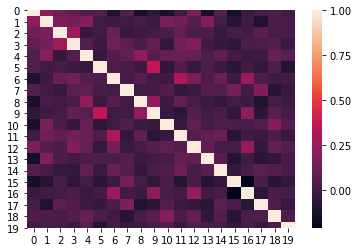

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [136]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:20,0:20]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(20))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(20):
    print(i,sim_matrix.index[i])


## Sense & Sensibility

In [137]:
#reading in the data, this time in the form of paragraphs
sense2=gutenberg.paras('austen-sense.txt')
#processing
sense_paras=[]
for paragraph in sense2:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    sense_paras.append(' '.join(para))

print(sense_paras[0:4])

['[ Sense and Sensibility by Jane Austen 1811 ]', 'CHAPTER 1', 'The family of Dashwood had long been settled in Sussex .', 'By a former marriage , Mr . Henry Dashwood had one son : by his present lady , three daughters .']


In [138]:
X_train2, X_test2 = train_test_split(sense_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words=stoplist, 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
sense_paras_tfidf=vectorizer.fit_transform(sense_paras)
print("Number of features: %d" % sense_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf2, X_test_tfidf2= train_test_split(sense_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr2 = X_train_tfidf2.tocsr()

#number of paragraphs
n = X_train_tfidf_csr2.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara2 = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr2.nonzero()):
    tfidf_bypara2[i][terms[j]] = X_train_tfidf_csr2[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train2[5])
print('Tf_idf vector:', tfidf_bypara2[5])

Number of features: 2051
Original sentence: " Nay , Edward ," said Marianne , " you need not reproach me .
Tf_idf vector: {'reproach': 0.5129885711936102, 'nay': 0.524999072102738, 'edward': 0.2997985561865538, 'said': 0.23409196183287145, 'need': 0.5129885711936102, 'marianne': 0.23104805788934007}


In [139]:
svd2= TruncatedSVD(130)
lsa2 = make_pipeline(svd2, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa2 = lsa2.fit_transform(X_train_tfidf2)

variance_explained2=svd2.explained_variance_ratio_
total_variance2 = variance_explained2.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component2=pd.DataFrame(X_train_lsa2,index=X_train2)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component2.loc[:,i].sort_values(ascending=False)[0:10])



Percent variance captured by all components: 42.01548049820076
Component 0:
" Marianne has not shyness to excuse any inattention of hers ," said Elinor .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        0.531888
Elinor said no more .                                         

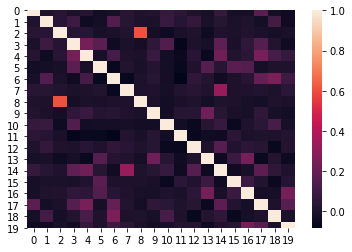

Key:
0 She paused . Her daughter could not quite agree with her , but her dissent was not heard , and therefore gave no offence .
1 Elinor DID think the question a very odd one , and her countenance expressed it , as she answered that she had never seen Mrs . Ferrars .
2 " I am extremely glad to hear it , upon my word ; extremely glad indeed .
3 How soon he had walked himself into the proper resolution , however , how soon an opportunity of exercising it occurred , in what manner he expressed himself , and how he was received , need not be particularly told .
4 " He WOULD have told me so , I doubt not , had I made any such inquiries , but they happened to be points on which I had been previously informed ."
5 " Nay , Edward ," said Marianne , " you need not reproach me .
6 Their man - servant had been sent one morning to Exeter on business ; and when , as he waited at table , he had satisfied the inquiries of his mistress as to the event of his errand , this was his voluntary communica

In [372]:
# Compute document similarity using LSA components
similarity2 = np.asarray(np.asmatrix(X_train_lsa2) * np.asmatrix(X_train_lsa2).T)
#Only taking the first 10 sentences
sim_matrix2=pd.DataFrame(similarity2,index=X_train2).iloc[0:20,0:20]
#Making a plot
ax = sns.heatmap(sim_matrix2,yticklabels=range(20))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(20):
    print(i,sim_matrix2.index[i])

## Persuasion

In [141]:
#reading in the data, this time in the form of paragraphs
persuasion2=gutenberg.paras('austen-persuasion.txt')
#processing
persuasion_paras=[]
for paragraph in persuasion2:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    persuasion_paras.append(' '.join(para))

print(persuasion_paras[0:4])

['[ Persuasion by Jane Austen 1818 ]', 'Chapter 1', 'Sir Walter Elliot , of Kellynch Hall , in Somersetshire , was a man who , for his own amusement , never took up any book but the Baronetage ; there he found occupation for an idle hour , and consolation in a distressed one ; there his faculties were roused into admiration and respect , by contemplating the limited remnant of the earliest patents ; there any unwelcome sensations , arising from domestic affairs changed naturally into pity and contempt as he turned over the almost endless creations of the last century ; and there , if every other leaf were powerless , he could read his own history with an interest which never failed .', '" ELLIOT OF KELLYNCH HALL .']


In [142]:
X_train3, X_test3 = train_test_split(persuasion_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words=stoplist, 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
persuasion_paras_tfidf=vectorizer.fit_transform(persuasion_paras)
print("Number of features: %d" % persuasion_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf3, X_test_tfidf3= train_test_split(persuasion_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr3 = X_train_tfidf3.tocsr()

#number of paragraphs
n = X_train_tfidf_csr3.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara3 = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr3.nonzero()):
    tfidf_bypara3[i][terms[j]] = X_train_tfidf_csr3[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train3[5])
print('Tf_idf vector:', tfidf_bypara3[5])

Number of features: 1330
Original sentence: " My expressions startle you .
Tf_idf vector: {'expressions': 1.0}


In [143]:
svd3= TruncatedSVD(130)
lsa3 = make_pipeline(svd3, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa3 = lsa3.fit_transform(X_train_tfidf3)

variance_explained3=svd3.explained_variance_ratio_
total_variance3 = variance_explained3.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component3=pd.DataFrame(X_train_lsa3,index=X_train3)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component3.loc[:,i].sort_values(ascending=False)[0:10])



Percent variance captured by all components: 42.01548049820076
Component 0:
From this time Captain Wentworth and Anne Elliot were repeatedly in the same circle .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        0.453407
This was an opportunity which Anne could not resist ; she said , therefore , " I hope , Admiral , I hope there is nothing in the style of Captain Wentworth ' s letter to make you and Mrs Croft particularly uneasy .                                

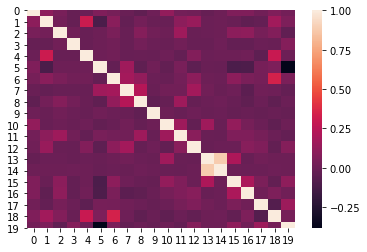

Key:
0 When the evening was over , Anne could not but be amused at the idea of her coming to Lyme to preach patience and resignation to a young man whom she had never seen before ; nor could she help fearing , on more serious reflection , that , like many other great moralists and preachers , she had been eloquent on a point in which her own conduct would ill bear examination .
1 The nights were too dark for the ladies to meet again till the morrow , but Captain Harville had promised them a visit in the evening ; and he came , bringing his friend also , which was more than had been expected , it having been agreed that Captain Benwick had all the appearance of being oppressed by the presence of so many strangers .
2 " No ," cried Anne , quickly , " it cannot be Mr Elliot , I assure you .
3 She paused a moment to recover from the emotion of hearing herself so spoken of .
4 Captain Harville smiled , as much as to say , " Do you claim that for your sex ?"
5 " My expressions startle you .


In [371]:
# Compute document similarity using LSA components
similarity3 = np.asarray(np.asmatrix(X_train_lsa3) * np.asmatrix(X_train_lsa3).T)
#Only taking the first 10 sentences
sim_matrix3=pd.DataFrame(similarity3,index=X_train3).iloc[0:20,0:20]
#Making a plot
ax = sns.heatmap(sim_matrix3,yticklabels=range(20))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(20):
    print(i,sim_matrix3.index[i])

Many of these sentences don't seem to offer much insight, but I like to see when there is an obvious correlation, or to even see how Emma and Sense & Sensibility's heatmaps were mostly dark, while Persusasion's is much more the same middle color.

## Implementing LDA with Gensim

Each topic modeling method seems to have pros and cons so et's try LDA with Gensim and see if we get different results. We'll begin again by importing packages.

In [352]:
import sys
from pprint import pprint

# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 
                   'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'think', 'see', 'rather', 'easy', 
                   'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 
                   'also', 'may', 'take', 'come', 'emma', 'adelaide', 'chapter', 'volume', 'dashwood', 'ferrar', 'captain_wentworth'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [325]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(emma))

print(data_words[:4])

[['emma', 'by', 'jane', 'austen'], ['volume'], ['chapter'], ['emma', 'woodhouse', 'handsome', 'clever', 'and', 'rich', 'with', 'comfortable', 'home', 'and', 'happy', 'disposition', 'seemed', 'to', 'unite', 'some', 'of', 'the', 'best', 'blessings', 'of', 'existence', 'and', 'had', 'lived', 'nearly', 'twenty', 'one', 'years', 'in', 'the', 'world', 'with', 'very', 'little', 'to', 'distress', 'or', 'vex', 'her']]


In [326]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['emma', 'by', 'jane', 'austen']


In [327]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [328]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:5])

[[], [], [], ['clever', 'rich', 'comfortable', 'happy', 'disposition', 'seem', 'unite', 'good', 'blessing', 'existence', 'live', 'nearly', 'year', 'world', 'little', 'distress'], ['young', 'daughter', 'affectionate', 'indulgent', 'mistress', 'early', 'period', 'mother', 'die', 'long', 'ago', 'indistinct', 'remembrance', 'caress', 'place', 'supply', 'excellent', 'woman', 'governess', 'fall', 'little', 'short', 'mother', 'affection']]


In [329]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:5])

[[], [], [], [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(8, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)]]


In [331]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=4,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
                                           

/opt/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:821: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [332]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.067*"must" + 0.040*"may" + 0.024*"sure" + 0.024*"think" + 0.021*"go" + '
  '0.021*"cry" + 0.020*"love" + 0.020*"know" + 0.020*"talk" + 0.019*"great"'),
 (1,
  '0.049*"much" + 0.038*"give" + 0.033*"little" + 0.027*"first" + '
  '0.027*"indeed" + 0.023*"word" + 0.022*"poor" + 0.022*"well" + '
  '0.018*"however" + 0.017*"answer"'),
 (2,
  '0.059*"friend" + 0.037*"perhaps" + 0.032*"long" + 0.029*"ought" + '
  '0.026*"still" + 0.022*"less" + 0.021*"thought" + 0.021*"daughter" + '
  '0.019*"pass" + 0.016*"serious"'),
 (3,
  '0.044*"never" + 0.036*"soon" + 0.034*"speak" + 0.034*"always" + '
  '0.031*"feel" + 0.028*"wish" + 0.027*"day" + 0.023*"happiness" + '
  '0.023*"find" + 0.018*"morning"'),
 (4,
  '0.058*"time" + 0.031*"man" + 0.030*"believe" + 0.030*"smile" + 0.028*"call" '
  '+ 0.024*"mind" + 0.023*"really" + 0.022*"yet" + 0.020*"thing" + '
  '0.019*"spirit"'),
 (5,
  '0.082*"say" + 0.048*"look" + 0.039*"hear" + 0.038*"ever" + 0.037*"tell" + '
  '0.036*"thing" + 0.035*"make" +

In [333]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.622155214972478

Coherence Score:  0.35978156918896076


Our coherence score is not very high, but it seems the only way to raise it is to introduce more topics and when that is done, some topics are repeated. That isn't ideal so we'll leave it as it is.

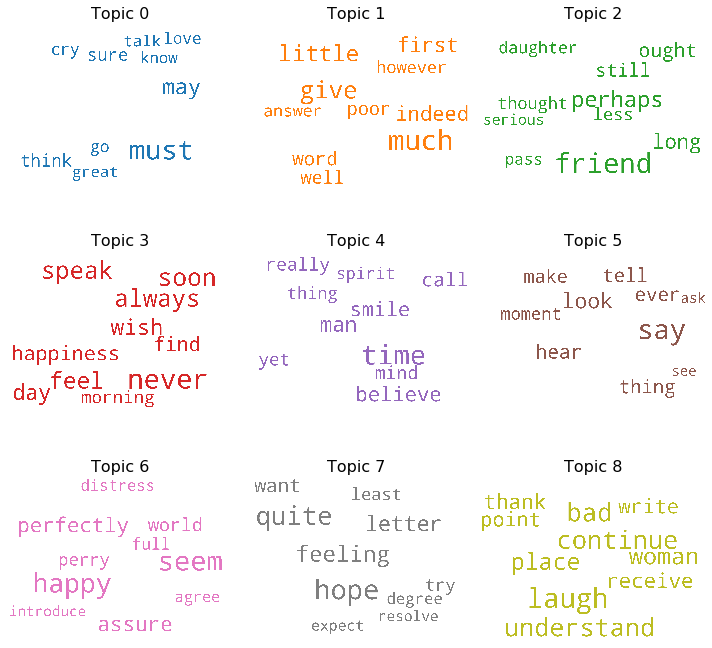

In [334]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

These topics seem much more naturally correlated than our previous NMF modeling. None of these topics seem clearly feminist, but they do seem more related.

## LDA with Persuasion

In [336]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

pers_words = list(sent_to_words(persuasion2))

print(pers_words[:4])

[['persuasion', 'by', 'jane', 'austen'], ['chapter'], ['sir', 'walter', 'elliot', 'of', 'kellynch', 'hall', 'in', 'somersetshire', 'was', 'man', 'who', 'for', 'his', 'own', 'amusement', 'never', 'took', 'up', 'any', 'book', 'but', 'the', 'baronetage', 'there', 'he', 'found', 'occupation', 'for', 'an', 'idle', 'hour', 'and', 'consolation', 'in', 'distressed', 'one', 'there', 'his', 'faculties', 'were', 'roused', 'into', 'admiration', 'and', 'respect', 'by', 'contemplating', 'the', 'limited', 'remnant', 'of', 'the', 'earliest', 'patents', 'there', 'any', 'unwelcome', 'sensations', 'arising', 'from', 'domestic', 'affairs', 'changed', 'naturally', 'into', 'pity', 'and', 'contempt', 'as', 'he', 'turned', 'over', 'the', 'almost', 'endless', 'creations', 'of', 'the', 'last', 'century', 'and', 'there', 'if', 'every', 'other', 'leaf', 'were', 'powerless', 'he', 'could', 'read', 'his', 'own', 'history', 'with', 'an', 'interest', 'which', 'never', 'failed', 'this', 'was', 'the', 'page', 'at', 'wh

In [337]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(pers_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[pers_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[pers_words[0]]])

['persuasion', 'by', 'jane', 'austen']


In [338]:
# Remove Stop Words
pers_words_nostops = remove_stopwords(pers_words)

# Form Bigrams
pers_words_bigrams = make_bigrams(pers_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
pers_lemmatized = lemmatization(pers_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(pers_lemmatized[:5])

[[], [], ['elliot', 'man', 'amusement', 'never', 'take', 'book', 'baronetage', 'find', 'occupation', 'idle', 'hour', 'consolation', 'distress', 'faculty', 'rouse', 'admiration', 'respect', 'contemplate', 'limit', 'remnant', 'early', 'patent', 'unwelcome', 'sensation', 'arise', 'domestic', 'affair', 'change', 'naturally', 'pity', 'contempt', 'turn', 'almost', 'endless', 'creation', 'last', 'century', 'leaf', 'powerless', 'read', 'history', 'interest', 'never', 'fail', 'page', 'favourite', 'always', 'open'], [], ['bear', 'lady', 'die', 'issue', 'bear', 'bear', 'still', 'bear', 'son', 'bear']]


In [339]:
# Create Dictionary
pers_id2word = corpora.Dictionary(pers_lemmatized)

# Create Corpus
pers_texts = pers_lemmatized

# Term Document Frequency
pers_corpus = [pers_id2word.doc2bow(text) for text in pers_texts]

# View
print(pers_corpus[:5])

[[], [], [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)], [], [(47, 5), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)]]


In [340]:
# Build LDA model
pers_lda_model = gensim.models.ldamodel.LdaModel(corpus=pers_corpus,
                                           id2word=pers_id2word,
                                           num_topics=10, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=4,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=False)
                                           

In [341]:
# Print the Keyword in the 10 topics
pprint(pers_lda_model.print_topics())
pers_lda = pers_lda_model[pers_corpus]

[(0,
  '0.125*"friend" + 0.118*"may" + 0.052*"profession" + 0.045*"wife" + '
  '0.026*"belong" + 0.026*"income" + 0.025*"mental" + 0.024*"absolutely" + '
  '0.023*"pass" + 0.021*"suppose"'),
 (1,
  '0.035*"say" + 0.024*"feel" + 0.016*"much" + 0.015*"see" + '
  '0.015*"tenderness" + 0.015*"little" + 0.014*"improvement" + 0.014*"wish" + '
  '0.014*"room" + 0.013*"perfectly"'),
 (2,
  '0.079*"day" + 0.079*"word" + 0.045*"add" + 0.043*"lose" + 0.039*"answer" + '
  '0.037*"hand" + 0.025*"sink" + 0.018*"stand" + 0.015*"welcome" + '
  '0.013*"captain_wentworth"'),
 (3,
  '0.064*"bear" + 0.061*"fix" + 0.012*"accordingly" + 0.004*"unnecessary" + '
  '0.004*"die" + 0.001*"cool" + 0.001*"sufferer" + 0.001*"medium" + '
  '0.001*"supplant" + 0.001*"unintentionally"'),
 (4,
  '0.056*"must" + 0.036*"look" + 0.035*"give" + 0.028*"happy" + 0.027*"hope" + '
  '0.023*"love" + 0.020*"enough" + 0.019*"never" + 0.019*"make" + '
  '0.019*"however"'),
 (5,
  '0.075*"short" + 0.068*"future" + 0.044*"doubt" + 0

In [342]:
# Compute Perplexity
print('\nPerplexity: ', pers_lda_model.log_perplexity(pers_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_pers_lda = CoherenceModel(model=pers_lda_model, texts=pers_lemmatized, dictionary=pers_id2word, coherence='c_v')
pers_coherence_lda = coherence_pers_lda.get_coherence()
print('\nCoherence Score: ', pers_coherence_lda)


Perplexity:  -9.08714469123587

Coherence Score:  0.3627759142969273


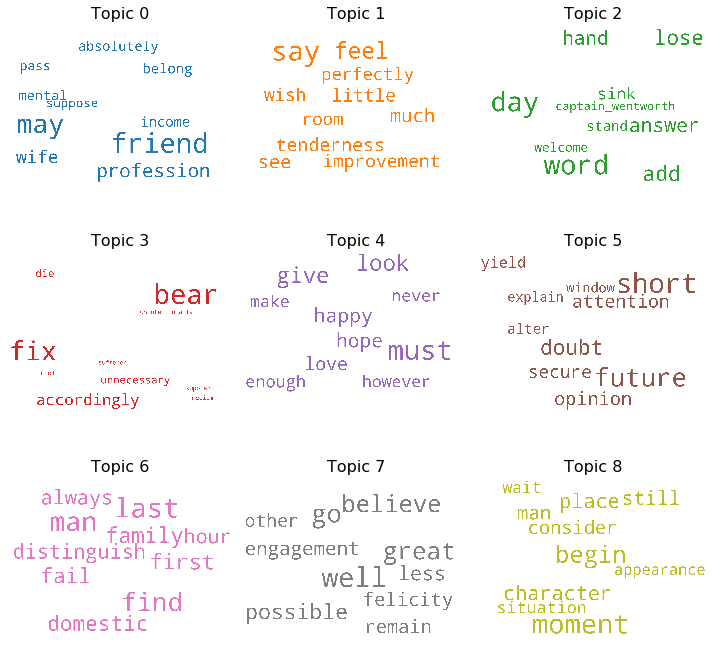

In [343]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

pers_topics = pers_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(pers_topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Sense & Sensibility LDA

In [344]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

sense_words = list(sent_to_words(sense2))

print(sense_words[:4])

[['sense', 'and', 'sensibility', 'by', 'jane', 'austen'], ['chapter'], ['the', 'family', 'of', 'dashwood', 'had', 'long', 'been', 'settled', 'in', 'sussex', 'their', 'estate', 'was', 'large', 'and', 'their', 'residence', 'was', 'at', 'norland', 'park', 'in', 'the', 'centre', 'of', 'their', 'property', 'where', 'for', 'many', 'generations', 'they', 'had', 'lived', 'in', 'so', 'respectable', 'manner', 'as', 'to', 'engage', 'the', 'general', 'good', 'opinion', 'of', 'their', 'surrounding', 'acquaintance', 'the', 'late', 'owner', 'of', 'this', 'estate', 'was', 'single', 'man', 'who', 'lived', 'to', 'very', 'advanced', 'age', 'and', 'who', 'for', 'many', 'years', 'of', 'his', 'life', 'had', 'constant', 'companion', 'and', 'housekeeper', 'in', 'his', 'sister', 'but', 'her', 'death', 'which', 'happened', 'ten', 'years', 'before', 'his', 'own', 'produced', 'great', 'alteration', 'in', 'his', 'home', 'for', 'to', 'supply', 'her', 'loss', 'he', 'invited', 'and', 'received', 'into', 'his', 'house

In [345]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(sense_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[sense_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[sense_words[0]]])

['sense', 'and', 'sensibility', 'by', 'jane', 'austen']


In [353]:
# Remove Stop Words
sense_words_nostops = remove_stopwords(sense_words)

# Form Bigrams
sense_words_bigrams = make_bigrams(sense_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
sense_lemmatized = lemmatization(sense_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(sense_lemmatized[:5])

[[], [], ['family', 'long', 'settle', 'sussex', 'estate', 'large', 'property', 'generation', 'live', 'respectable', 'manner', 'engage', 'general', 'opinion', 'surround', 'late', 'owner', 'single', 'man', 'live', 'advanced', 'age', 'year', 'constant', 'death', 'happen', 'year', 'produce', 'great', 'alteration', 'home', 'supply', 'invite', 'receive', 'family', 'person', 'intend', 'children', 'old', 'day', 'comfortably', 'spend', 'attachment', 'increase', 'constant', 'attention', 'proceed', 'merely', 'interest', 'goodness', 'heart', 'give', 'degree', 'solid', 'comfort', 'age', 'receive', 'cheerfulness', 'child', 'add', 'relish', 'existence'], ['former', 'marriage', 'son', 'daughter', 'son', 'steady', 'amply', 'provide', 'fortune', 'mother', 'large', 'devolve', 'come', 'age', 'marriage', 'likewise', 'happen', 'soon', 'afterwards', 'add', 'wealth', 'therefore', 'estate', 'really', 'important', 'sister', 'fortune', 'independent', 'may', 'arise', 'inherit', 'property', 'small', 'mother', 'fat

In [354]:
# Create Dictionary
sense_id2word = corpora.Dictionary(sense_lemmatized)

# Create Corpus
sense_texts = sense_lemmatized

# Term Document Frequency
sense_corpus = [sense_id2word.doc2bow(text) for text in sense_texts]

# View
print(sense_corpus[:5])

[[], [], [(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 2)], [(0, 1), (2, 1), (7, 1), (16, 1), (24, 1), (29, 1), (31, 1), (44, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 3), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1)], [(5, 1), (7, 2), (16, 2), (21, 1), (38, 2), (45, 1), (55, 3), (60, 2), (76, 1), (79, 1), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (9

In [355]:
# Build LDA model
sense_lda_model = gensim.models.ldamodel.LdaModel(corpus=sense_corpus,
                                           id2word=sense_id2word,
                                           num_topics=8, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=4,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=False)
                                           

In [356]:
# Print the Keyword in the 10 topics
pprint(sense_lda_model.print_topics())
sense_lda = sense_lda_model[sense_corpus]

[(0,
  '0.061*"ferrar" + 0.044*"well" + 0.029*"perhaps" + 0.028*"marry" + '
  '0.026*"still" + 0.025*"woman" + 0.024*"strong" + 0.020*"conduct" + '
  '0.019*"suffer" + 0.016*"eye"'),
 (1,
  '0.086*"say" + 0.069*"always" + 0.030*"shall" + 0.029*"end" + 0.028*"world" '
  '+ 0.025*"expect" + 0.024*"certainly" + 0.022*"away" + 0.021*"word" + '
  '0.020*"self"'),
 (2,
  '0.036*"however" + 0.031*"make" + 0.026*"tell" + 0.025*"heart" + '
  '0.024*"feel" + 0.024*"mean" + 0.023*"much" + 0.022*"know" + 0.022*"little" '
  '+ 0.021*"day"'),
 (3,
  '0.028*"family" + 0.026*"great" + 0.025*"long" + 0.018*"constant" + '
  '0.017*"merit" + 0.017*"call" + 0.016*"produce" + 0.016*"interest" + '
  '0.015*"fear" + 0.014*"naturally"'),
 (4,
  '0.051*"live" + 0.034*"find" + 0.024*"hour" + 0.022*"look" + 0.022*"moment" '
  '+ 0.021*"remain" + 0.021*"speak" + 0.020*"come" + 0.017*"hope" + '
  '0.016*"considerable"'),
 (5,
  '0.035*"must" + 0.028*"never" + 0.027*"hear" + 0.022*"brother" + '
  '0.022*"happy" + 0

In [357]:
# Compute Perplexity
print('\nPerplexity: ', sense_lda_model.log_perplexity(sense_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_sense_lda = CoherenceModel(model=sense_lda_model, texts=sense_lemmatized, dictionary=sense_id2word, coherence='c_v')
sense_coherence_lda = coherence_sense_lda.get_coherence()
print('\nCoherence Score: ', sense_coherence_lda)


Perplexity:  -8.605043698506448

Coherence Score:  0.40244398641266244


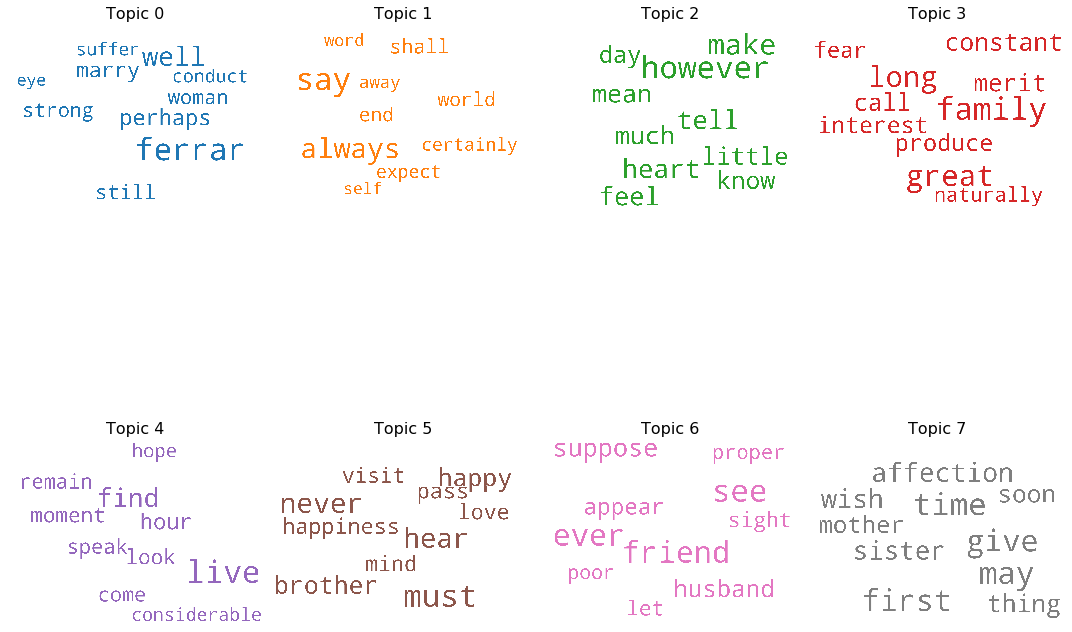

In [358]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

sense_topics = sense_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(sense_topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Conclusion

I've done a lot of work here to see what methods might be able to most easily detect feminist sentiment. Nothing seems to clearly show feminism so we can conclude one of two things: 1) Jane Austen is not a feminist author. 2) Our methods are not quite sophisticated enough. Maybe one day we will be able to conclude one or the other more conclusively and mathematically, but I don't think we can do so just yet.